# Final Project Social Graphs

In [1]:
import wikipedia
from bs4 import BeautifulSoup
import os
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
import urllib
import re
from wordcloud import WordCloud

## 1. Introduction:


We have chosen to analyze and investigate how conflicts and wars throughout the last 2500 years have shaped and impacted the great empires of the time as well as individual countries. Some empires/countries do still exist today, whereas the majority has disappeared into oblivion or evolved into other or smaller countries and/or territories. 


The motivation we have is to learn how a conflict could develop into war and what was the impact of participating in this war? Can we determine an imperial success based on the number of conflicts or wars or has the consequences of participating always led to annihilation or destruction? We work with the theory that being in a conflict or war has only been beneficial for a certain part of history and thus keeping out of conflicts could lead to more peace and prosperity in a longer period.


We have created a website that will allow the user to navigate the history of wars and conflicts based on a historical timeline from 500 BC up till modern times and the 21st century. We will create the content on the website by using network analysis tools.


We aim to ensure that the user will gain insights on this topic no matter if the user has limited pre-knowledge or is historically literate with an interest in conflicts and wars. As we, ourselves, are historically interested, we hope that this website will bring light on a complex and detailed topic with easy access to the data and that the users will gain knowledge from the website.


## 2. Data


**Dataset:**

In order to make this network analysis countries are set as nodes and edges represent the conflicts/wars as well as equivalences between countries. The countries are connected in the network if Wikipedia lists the countries as being a part of conflict/war. During the analysis we will also group any alliances during time-based on the nodes and any victory in the conflict/war will be shown in the edges.


To get the data to this analysis we are relying on Wikipedia to provide the list of countries and conflicts/wars. The lists include both minor and major conflicts, some conflicts even forgotten by general knowledge, but we have chosen to keep all data as provided by Wikipedia in the analysis. We are aware that we are relying completely on the accuracy of Wikipedia and that this source can be open for mistakes, but the general picture and network of conflicts and wars are still sufficient for the purpose of our website.


* The link for the lists:
* https://en.wikipedia.org/wiki/List_of_wars:_before_1000
* https://en.wikipedia.org/wiki/List_of_wars:_1000%E2%80%931499
* https://en.wikipedia.org/wiki/List_of_wars:_1500%E2%80%931799
* https://en.wikipedia.org/wiki/List_of_wars:_1800%E2%80%931899
* https://en.wikipedia.org/wiki/List_of_wars:_1900%E2%80%931944
* https://en.wikipedia.org/wiki/List_of_wars:_1945%E2%80%931989
* https://en.wikipedia.org/wiki/List_of_wars:_1990%E2%80%932002
* https://en.wikipedia.org/wiki/List_of_wars:_2003%E2


### 2.1. Web-scraping


In [2]:
war_class_list = ["List of wars before 1000", "List of wars: 1000–1499", "List of wars: 1500–1799", "List of wars: 1800–1899", "List of wars: 1900–1944", "List of wars: 1945–1989", "List of wars: 1990–2002", "List of wars: 2003–present", "List of ongoing armed conflicts", "List of conflicts by duration"]

In [3]:
war_class_list

['List of wars before 1000',
 'List of wars: 1000–1499',
 'List of wars: 1500–1799',
 'List of wars: 1800–1899',
 'List of wars: 1900–1944',
 'List of wars: 1945–1989',
 'List of wars: 1990–2002',
 'List of wars: 2003–present',
 'List of ongoing armed conflicts',
 'List of conflicts by duration']

In [4]:
#war_html_list = [wikipedia.WikipediaPage(title=war).html() for war in war_class_list]
#war_table_html_list = [BeautifulSoup(war_html, 'html.parser').find('table',{'class':"wikitable"}) for war_html in war_html_list]
#war_table_list = [pd.read_html(str(war_html)) for war_html in war_table_html_list]

import pickle
pickle_file = open("war_table_list.pickle", "rb")
war_table_list = pickle.load(pickle_file)

In [5]:
periods_before_1000 = pd.DataFrame(war_table_list[0][0]).copy()
periods_before_1000.columns = ['start','finish','name','victorious','defeated']
periods_before_1000.start = periods_before_1000.start.apply(lambda x: x.replace('c. ','-')[:5])
periods_before_1000.finish = periods_before_1000.finish.apply(lambda x: x.replace('c. ','-')[:5])

periods_1000_1499 = pd.DataFrame(war_table_list[1][0]).copy()
periods_1000_1499.columns = ['start','finish','name','victorious','defeated']
periods_1000_1499.start = periods_1000_1499.start.apply(lambda x: x[:4])
periods_1000_1499.finish = periods_1000_1499.finish.apply(lambda x: x[:4])

periods_1500_1799 = pd.DataFrame(war_table_list[2][0]).copy()
periods_1500_1799.columns = ['start','finish','name','victorious','defeated']

periods_1800_1899 = pd.DataFrame(war_table_list[3][0]).copy()
periods_1800_1899.columns = ['start','finish','name','victorious','defeated']

periods_1900_1944 = pd.DataFrame(war_table_list[4][0]).copy()
periods_1900_1944.columns = ['start','finish','name','victorious','defeated']
periods_1900_1944 = periods_1900_1944[(periods_1900_1944.finish != '1916 (Solor) 1940 (Flores)')&(periods_1900_1944.finish != '1910/1914')]

periods_1945_1989 = pd.DataFrame(war_table_list[5][0]).copy()
periods_1945_1989.columns = ['start','finish','name','victorious','defeated']
periods_1945_1989 = periods_1945_1989[(periods_1945_1989.finish != 'Ongoing') & (periods_1945_1989.finish != 'ongoing')]
periods_1945_1989.drop(21,axis=0,inplace=True)
periods_1945_1989.start = periods_1945_1989.start.apply(lambda x: x[-4:])
periods_1945_1989.finish = periods_1945_1989.finish.apply(lambda x: x[-4:])

periods_1990_2002 = pd.DataFrame(war_table_list[6][0])
periods_1990_2002.columns = ['start','finish','name','victorious','defeated']

periods_2003_2021 = pd.DataFrame(war_table_list[7][0])
periods_2003_2021 = periods_2003_2021[periods_2003_2021.columns[:5]]
periods_2003_2021.columns = ['start','finish','name','victorious','defeated']
periods_2003_2021 = periods_2003_2021[(periods_2003_2021.finish != 'Ongoing') & (periods_2003_2021.finish != 'ongoing')]

In [6]:
war_data = pd.DataFrame([])
war_data = pd.concat([periods_before_1000, periods_1000_1499, periods_1500_1799, periods_1800_1899, periods_1900_1944, periods_1945_1989, periods_1990_2002, periods_2003_2021], axis = 0)
war_data = war_data[(war_data.finish != 'Ongoing') & (war_data.finish != 'ongoing')&(war_data.finish != 'befor')&(war_data.finish != 'present')&(war_data.finish != '2009/2013')]
war_data.start = war_data.start.astype('int')
war_data.finish = war_data.finish.astype('int')
war_data['century'] = -(-(war_data.start + (war_data.finish - war_data.start)/2) // 100).astype(int)

In [7]:
war_data

,start,finish,name,victorious,defeated,century
0,-3250,-3250,"Campaign by King Scorpion (I) against King ""Ta...",Upper Egypt under Scorpion I,Forces of Taurus (Bull),-32
1,-3150,-3150,Narmer's campaign against WashExistence disputed,Upper Egypt under Narmer,Forces of Wash,-31
2,-3100,-3100,Unification of Upper and Lower Egypt,Upper Egypt under Narmer,Lower Egypt,-31
3,-3100,-3100,Hor-Aha's Nubia Campaign,Egypt,Nubia,-31
4,-2900,-2900,Civil war between Horus Bird and Sneferka[1][2...,NaN,NaN,-29
...,...,...,...,...,...,...
101,2019,2019,Gaza–Israel clashes (November 2019),Israel,Palestinian Islamic Jihad,21
104,2020,2020,Second Nagorno-Karabakh war,Azerbaijan Syrian mercenaries Supported by: T...,Armenia Artsakh Armenian diaspora volunteers ...,21
110,2021,2021,Kyrgyzstan–Tajikistan clashes,Kyrgyzstan,Tajikistan,21
111,2021,2021,2021 Israel–Palestine crisis,Israel Jewish Israeli protesters,Gaza Strip Hamas Palestinian Islamic Jihad ...,21


In [8]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def check_if_country_actual(country):
  try:
      country_code = country_name_to_country_alpha2(country, cn_name_format="default")
      return True
  except:
      return False

In [9]:
check_if_country_actual("Great Britain")

True

In [ ]:
all_countries = set(war_data["defeated"].tolist())
all_countries = set.union(all_countries, war_data["victorious"].tolist())
all_countries = {x for x in all_countries if pd.notna(x)}
print(all_countries)

In [11]:
len(all_countries)

927

Here we attempt to map the country names into modern day equivalencies if applicable. Otherwise they can be sorted into sets of coalitions, current countries, or other.

In [12]:
from collections import defaultdict

# No current country
no_current_countries = set()
# Country coalitions
coalitions = set()
# Not mapped
not_mapped= set()
# Country coalitions
current_countries = set()

# Mapping
countries_and_coalitions_mapping = defaultdict(lambda: set())

country_mapping = {'United Kingdom':'Great Britain', 
                   'Castilians':'Spain', 
                   'Castille':'Spain',
                   'Spanish EmpireTlaxcala': 'Spain',
                   'Spanish Spanish Empire': 'Spain',
                   'Kingdom of Navarre ': 'Spain',
                   'Kingdom of Aragon': 'Spain',
                   'Polish–Lithuanian Commonwealth': {'Poland','Lithuania'},
                   'Polish worker militias':'Poland',
                   'Portugual': 'Portugal',
                   'Portuguese Empire': 'Portugal',
                   'Portuguese Empire Tamoio People': 'Portugal',
                   'Portuguese Empire[11]': 'Portugal',
                   'Portuguese Empire\xa0Ethiopian Empire': {'Portugal','Ethiopia'},
                   'Tibetan Buddhists': {'China','Tibet'},
                   'Spanish colonists Guaraní': 'Spain',
                   'Society of United Irishmen': 'Ireland',
                   'Yugoslavia': {'Serbia','Bosnia and Herzegovina', 'Croatia'},
                   'Spanish Empire':'Spain', 
                   'Empire of Japan':'Japan',
                   'Grand Duchy of Lithuania':'Lithuania',
                   'United Nations':'United Nations',
                   'The Netherlands':'Netherlands',
                   'Austrian Empire': {'Austria','Hungary'},
                   'Russian Empire': 'Russia',
                   'Denmark–Norway': {'Denmark','Norway'},
                   'Hellenic Macedonian Committee': {'Greece','Macedonia'},
                   'Swiss Confederation': 'Switzerland',
                   'Holland ': 'Netherlands',
                   'Dutch Empire': 'Netherlands',
                   'Uruguayan government': 'Uruguay',
                   'Royalists of Aragon': 'Spain',
                   'Portugual': 'Portugal',
                   'Russian Federation': 'Russia',
                   'RomaniaSupported by:\xa0Soviet Union': 'Romania',
                   'Romanian peasants': 'Romania',
                   'Tibetan Buddhists': {'China','Tibet'},
                   'Uruk': 'Sumer',
                   'Uruk (Sumer)': 'Sumer',
                   }

for n in all_countries:
    country_found = False

    if check_if_country_actual(n):
        current_countries.add(n)
    else:
        if isinstance(n, str) and len(n.split()) > 4:
            coalitions.add(n)

            if n in list(country_mapping.keys()):
                  countries_and_coalitions_mapping[n].add(country_mapping[n])
                  country_found = True

            for idx, word in enumerate(n.split()):
                if check_if_country_actual(word):
                    countries_and_coalitions_mapping[n].add(word)
                    country_found = True

                elif idx+2 < len(n.split()): 
                    if check_if_country_actual(word + (n.split()[idx+1])):
                      countries_and_coalitions_mapping[n].add(word + n.split()[idx+1])
                      country_found = True
                
                elif n in country_mapping.keys():
                    if isinstance(country_mapping[n], set):
                      countries_and_coalitions_mapping[n] |= country_mapping[n]
                    else:
                      countries_and_coalitions_mapping[n].add(country_mapping[n])
                    country_found = True


        elif isinstance(n, str):

            no_current_countries.add(n)

            if n in list(country_mapping.keys()):
                  if isinstance(country_mapping[n], set):
                      countries_and_coalitions_mapping[n] |= country_mapping[n]
                  else:
                      countries_and_coalitions_mapping[n].add(country_mapping[n])
                  country_found = True

            else:
              for idx, word in enumerate(n.split()):
                  if check_if_country_actual(word):
                      countries_and_coalitions_mapping[n].add(word)
                      country_found = True

                  elif idx+2 < len(n.split()): 
                      if check_if_country_actual(word + (n.split()[idx+1])):
                        countries_and_coalitions_mapping[n].add(word + n.split()[idx+1])
                        country_found = True

                  elif word in country_mapping.keys():
                    if isinstance(country_mapping[word], set):
                      countries_and_coalitions_mapping[n] |= country_mapping[word]
                    else:
                      countries_and_coalitions_mapping[n].add(country_mapping[word])
                    country_found = True

                  elif idx+2 < len(n.split()): 
                      if word in country_mapping.keys():
                        countries_and_coalitions_mapping[n].add(country_mapping[word + n.split()[idx+1]])
                        country_found = True


              if not(country_found):
                  not_mapped.add(n)


In [13]:
print(current_countries)

{'Russia', 'Rwanda', 'Eritrea', 'Nicaragua', 'Argentina', 'Tajikistan', 'Kingdom of Cambodia', 'Kingdom of Norway', 'Cambodia', 'Nigeria', 'Iraq', 'Kenya', 'Bangladesh', 'France', 'Slovenia', 'Croatia', 'Honduras', 'United States', 'Sri Lanka', 'Iran', 'India', 'Libya', 'Armenia', 'Spain', 'Mozambique', 'Saudi Arabia', 'Bolivia', 'Myanmar', 'Nepal', 'Mexico', 'Sweden', 'Israel', 'Philippines', 'El Salvador', 'China', 'Ethiopia', 'Lebanon', 'Albania', 'Uganda', 'Venezuela', 'Egypt', 'Thailand', 'Afghanistan', 'Ecuador', 'Georgia', 'Pakistan', 'United Kingdom', 'Congo', 'Kyrgyzstan', 'Indonesia', 'Sudan', 'South Korea', 'Haiti', 'Portugal', 'Namibia', 'Republic of the Congo', 'Bahrain', 'Djibouti', 'Azerbaijan', 'Peru', 'Yemen'}


### 2.2. Network construction


In [14]:
# Edge classes
class Conflict:
  def __init__(self, war, victorious, defeated, start, end):
    self.name = war
    self.victorious = victorious
    self.defeated = defeated


    self.start = start

    self.start = start
    self.end = end

class Equivalence:
  def __init__(self, current_country, country2):
    self.country1 = current_country
    self.country2 = country2

class Coalition:
  coalition_countries = []

  def __init__(self, name, century, coalition_countries = None, added_nodes = None, G = None):
    self.name = name

    if coalition_countries:
        for country in coalition_countries:
            if country in added_nodes.keys():
                self.coalition_countries.append(added_nodes[country])
            else:
                self.coalition_countries.append(Country(name=country, century=century, current=True))
        self.coalition_countries = coalition_countries

# Node classes
class Country:
  def __init__(self, name, century, code=None, current = False, mapping=None, added_nodes=None, G = None):
    self.name = name

    self.century = century

    if mapping:

      if name in mapping.keys():
        if name in added_nodes.keys():
          equivalent = added_nodes[name]
        else:
          equivalent = Country(name=list(mapping[name])[0], century=21, current=True)
      else:
        equivalent = Country(name=list(mapping[name])[0], century=21, current=True)
        self.name = list(mapping[name])[0]
        coalition_countries.append(added_nodes[country])
        self.current = current
        self.code = code
      
      if not(name == equivalent):
        G.add_edge(self, equivalent, label=Equivalence(self, equivalent))

    else:
      self.current = current
      self.code = code

In [15]:
def set_participant(participant, century, current_countries, coalitions, countries_and_coalitions_mapping, added_nodes, G):
    
    if participant not in current_countries:
        if participant in coalitions: # compose countries
            if participant in countries_and_coalitions_mapping.keys():
                participant = Coalition(participant, century, countries_and_coalitions_mapping[participant], added_nodes=added_nodes, G=G)
            else:
                participant = Coalition(participant, century)
        elif participant in countries_and_coalitions_mapping.keys():
            participant = Country(participant, century, mapping = countries_and_coalitions_mapping, added_nodes=added_nodes, G=G)
        else:
            participant = Country(participant, century)
    
    elif participant in added_nodes.keys():
      participant = added_nodes[participant]
    
    else:
      participant = Country(participant, 21)
    
    return participant

In [16]:
import networkx as nx

G = nx.DiGraph()

added_nodes = {}
added_confllicts = {}

added_links_coalition = {}
added_links_wars = {}


In [17]:
for idx, war in war_data.iterrows():

    start = war['start']
    finish = war['finish']

    century = war['century']

    war_name = war['name']
    

    victorious = war['victorious']
    defeated = war['defeated']

    
    victorious_object = set_participant(victorious, 
                                        century,
                                        current_countries, 
                                        coalitions,
                                        countries_and_coalitions_mapping,
                                        added_nodes,
                                        G
                                        )
          
    defeated_object = set_participant(defeated, 
                                    century,
                                    current_countries, 
                                    coalitions,
                                    countries_and_coalitions_mapping,
                                    added_nodes,
                                    G
                                    )

    added_nodes[victorious_object.name] = victorious_object
    added_nodes[defeated_object.name] = defeated_object

    if war_name in added_confllicts.keys():
        conflict_object =  added_confllicts[war_name]
    
    else:
        conflict_object = Conflict(war_name, victorious_object, defeated_object, start, finish)
        added_confllicts[conflict_object.name] = conflict_object
    
    previous_victorious = None
    previous_defeated = None

    if isinstance(victorious_object, Coalition) and isinstance(defeated_object, Coalition):
        for victorious in victorious_object.coalition_countries:
            
            if previous_victorious:
                G.add_edge(victorious, 
                            previous_victorious, 
                            label=victorious_object
                            )
                added_links_coalition[(victorious,previous_victorious)] = victorious_object.name
                
            previous_victorious = victorious

            for defeated in defeated_object.coalition_countries:
                if previous_defeated:
                    G.add_edge(defeated, 
                            previous_defeated, 
                            label=victorious_object
                            )
                    added_links_coalition[(defeated,previous_defeated)] = defeated_object.name
                
                previous_defeated = defeated

                G.add_edge(victorious, 
                        defeated, 
                        label=conflict_object
                        )
                added_links_wars[(victorious,defeated)] = conflict_object.name

    elif isinstance(victorious_object, Coalition):
        for victorious in victorious_object.coalition_countries:
            G.add_edge(victorious, 
                        defeated_object, 
                        label=conflict_object
                        )
            added_links_wars[(victorious,defeated_object)] = conflict_object.name
            #added_links_coalition[(victorious,defeated_object)] = conflict_object.name
        
    elif isinstance(defeated_object, Coalition):
        for defeated in defeated_object.coalition_countries:
            G.add_edge(victorious_object, 
                        defeated, 
                        label=conflict_object
                        )
            added_links_wars[(victorious_object,defeated)] = conflict_object.name
            #added_links_coalition[(defeated,defeated_object)] = defeated_object.name
    
    G.add_edge(victorious_object, 
                defeated_object, 
                label=conflict_object)
    added_links_wars[(victorious_object,defeated_object)] = conflict_object.name
                

In [18]:
import json

js_dict = dict(nodes=G.nodes(), edges=G.edges())

added_nodes = []

nodes = []
links = []

for country in G.nodes():
    if isinstance(country, Country):
        if not(isinstance(country.name, str)):
            name = "Nan"
        else:
            name = country.name

        nodes.append({
         "group": country.century, 
         "id": str(country), 
         "value": G.degree[country]/30, 
         "name": name
        }
        )

        added_nodes.append(country)

    elif isinstance(country, str):
        if not(isinstance(country, str)):
            name = "Nan"
        else:
            name = country

        nodes.append({
         "group": 21, 
         "id": country, 
         "value": G.degree[country]/30, 
         "name": name
        }
        )

        added_nodes.append(country)

for link in G.edges():
    if link[0] in added_nodes and link[1] in added_nodes:
        if link in added_links_wars.keys():
            
            if (added_links_wars[link]=="World War II"):
                print(added_links_wars[link])
                

            links.append({
            "source": str(link[0]), 
            "target": str(link[1]), 
            "relationship": 'war'
            })
        elif link in added_links_coalition.keys():
            links.append({
            "source": str(link[0]), 
            "target": str(link[1]), 
            "relationship": 'coalition'
            })

#print(nodes)

In [19]:
import json
with open('result.json', 'w') as fp:
    json.dump({"nodes":nodes, "links":links[:5000]}, fp)

In [20]:
for node in G.nodes():
    if nx.degree(G, node)==0:
        for_removal.append(node)

In [21]:
for_removal = []

for node in G.nodes():
    if nx.degree(G, node)==0:
        for_removal.append(node)

G.remove_nodes_from(for_removal)

In [22]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
G1 = G.subgraph(Gcc[1])
GU = G0.to_undirected()
GU1 = G1.to_undirected()

In [23]:
d = GU.degree()
d1 = GU1.degree()

sizes = []
labels = dict()

sizes1 = []
labels1 = dict()

# Color and sizes of nodes represent their roles and degrees respectively
for node in GU.nodes():
    if d[node]>1:
        labels[node] = str(node)
    sizes.append(d[node]*30)

for node in GU1.nodes():
    if d1[node]>1:
        labels1[node] = str(node)
    sizes1.append(d1[node]*30)

In [24]:
# The force atlas package is used to group nodes in a logical fashion
from fa2 import ForceAtlas2
#GU = G.to_undirected()
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=3.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=2000)



100%|██████████| 2000/2000 [00:39<00:00, 50.87it/s]BarnesHut Approximation  took  5.08  seconds
Repulsion forces  took  25.63  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  6.68  seconds
AdjustSpeedAndApplyForces step  took  0.54  seconds



In [25]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=3.0,

                        # Log
                        verbose=True)

positions1 = forceatlas2.forceatlas2_networkx_layout(GU1, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 46751.42it/s]BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds



## 3. Tools, theory and analysis

In [26]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of links: ', G.size())

Number of nodes:  1792
Number of links:  92402


In [27]:
tot_deg_list = []
in_deg_list = []
out_deg_list = []

for key, value in G.degree:
    tot_deg_list.append(value)
for key, value in G.in_degree:
    in_deg_list.append(value)
for key, value in G.out_degree:
    out_deg_list.append(value)

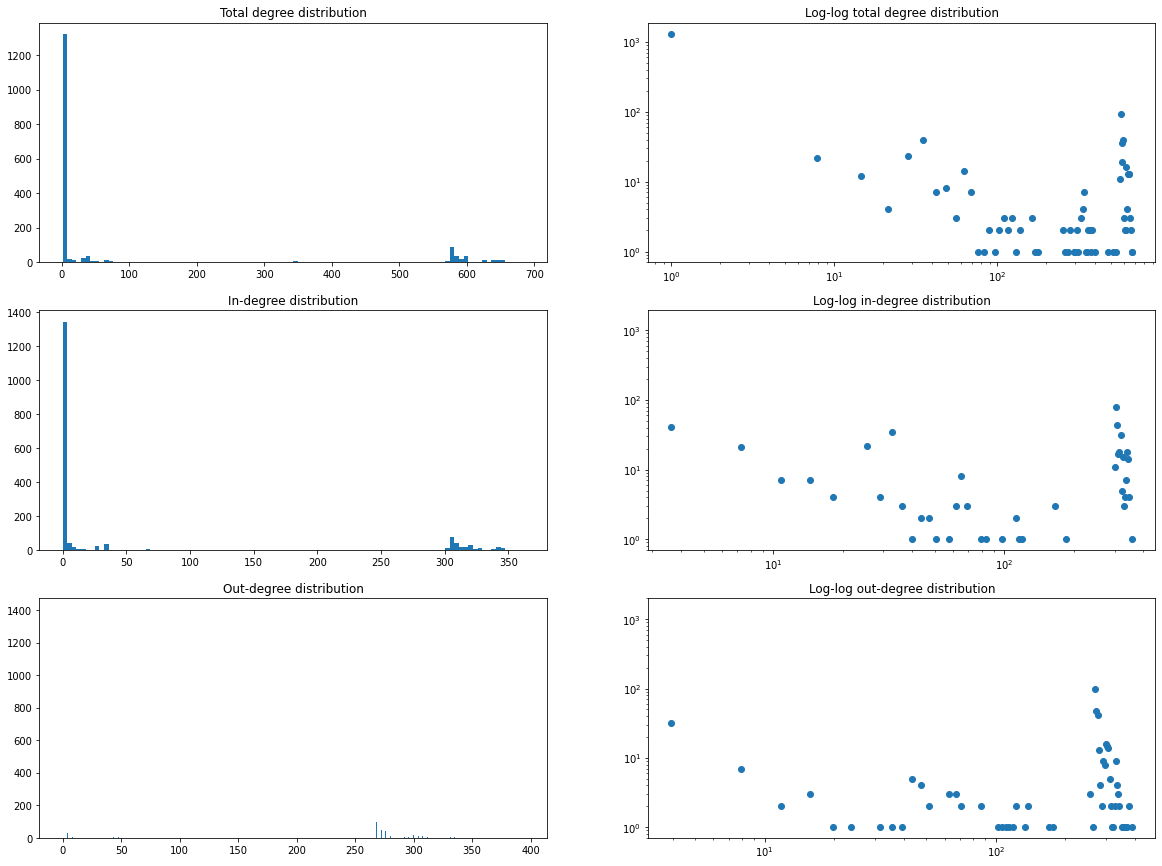

In [28]:
hist1, bins1 = np.histogram(tot_deg_list, 100)
hist2, bins2 = np.histogram(in_deg_list, 100)
hist3, bins3 = np.histogram(out_deg_list, 100)

fig, axes = plt.subplots(3, 2, figsize=(20,15))
axes[0,0].hist(tot_deg_list, bins=100)
axes[0,0].set_title('Total degree distribution')

axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].scatter(bins1[:-1],hist1)
axes[0,1].set_title('Log-log total degree distribution')

axes[1,0].hist(in_deg_list, bins=100)
axes[1,0].set_title('In-degree distribution')

axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')
axes[1,1].scatter(bins2[:-1],hist2)
axes[1,1].set_title('Log-log in-degree distribution')

axes[2,0].hist(out_deg_list, bins=100, width=0.8)
axes[2,0].set_title('Out-degree distribution')

axes[2,1].set_xscale('log')
axes[2,1].set_yscale('log')
axes[2,1].scatter(bins3[:-1],hist3)
axes[2,1].set_title('Log-log out-degree distribution')
fig.show()


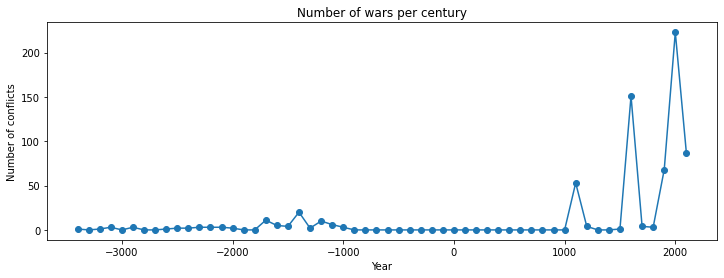

In [29]:
number_of_wars = []
for century in range(-34,22):
    number_of_wars.append(len(war_data[war_data['century'] == century]['name'].values))
plt.figure(figsize=(12, 4))
plt.plot(np.arange(-34,22)*100, number_of_wars,'-o')
plt.title('Number of wars per century')
plt.xlabel('Year')
plt.ylabel('Number of conflicts');

In [30]:
# Find top 10 countries with in/out degree
degree=list(G.degree())
degree.sort(key=lambda e: e[1], reverse=True)
for n in degree[:10]:
    in_degree = G.in_degree(n[0])
    out_degree = G.out_degree(n[0])
    print(f'The degree for country {n[0].name}:')
    print(f'In-degree:{in_degree}')
    print(f'Out-degree:{out_degree}')
    print(f'Total degree count:{n[1]}')

The degree for country Egypt:
In-degree:362
Out-degree:322
Total degree count:684
The degree for country Israel:
In-degree:309
Out-degree:363
Total degree count:672
The degree for country Hungary:
In-degree:351
Out-degree:313
Total degree count:664
The degree for country Poland:
In-degree:351
Out-degree:313
Total degree count:664
The degree for country France:
In-degree:344
Out-degree:318
Total degree count:662
The degree for country France:
In-degree:349
Out-degree:312
Total degree count:661
The degree for country Norway:
In-degree:348
Out-degree:310
Total degree count:658
The degree for country Georgia:
In-degree:347
Out-degree:309
Total degree count:656
The degree for country Azerbaijan:
In-degree:347
Out-degree:309
Total degree count:656
The degree for country France:
In-degree:347
Out-degree:309
Total degree count:656


In [31]:
def get_page(page_title):
    # API query
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + page_title
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = (f"{baseurl}{action}&{content}&{title}&{dataformat}")
    path = '/work/page'

    wiki_response = urllib.request.urlopen(query)
    wiki_data = wiki_response.read()
    wiki_text = wiki_data.decode('utf-8')

    wiki_json = json.loads(wiki_text)["query"]["pages"]
    key=next(iter(wiki_json))

    wiki_content = wiki_json[key]["revisions"][0]["*"]

    return wiki_content

In [32]:
from community import community_louvain
data_partitions = community_louvain.best_partition(G.to_undirected())
communities_dict = data_partitions.items()
communities_df = pd.DataFrame.from_dict(communities_dict)
communities_df = communities_df.rename(columns={0: 'name', 1: "community"})
war_data = war_data.join(communities_df.set_index('name'),on='name')
print(f'Number of communities: {max(communities_df.community)+1}')

Number of communities: 410


## Text analysis of Russo-Ukraine War

Here we dive a little deeper into a specific wikipedia page, with the help of a little text analysis.

In [33]:
R_U_war = get_page("Russo-Ukrainian_War")

In [34]:
RU_links = []
links = re.findall(r'\[\[[\w\s]+\]\]', R_U_war)
for link in links:
    match = re.search(r'\[\[([\w\s]+)\]\]', link)
    RU_links.append(match.group(1))

In [36]:
S_U_war = get_page("Soviet%E2%80%93Ukrainian_War")
SU_links = []
links = re.findall(r'\[\[[\w\s]+\]\]', S_U_war)
for link in links:
    match = re.search(r'\[\[([\w\s]+)\]\]', link)
    SU_links.append(match.group(1))

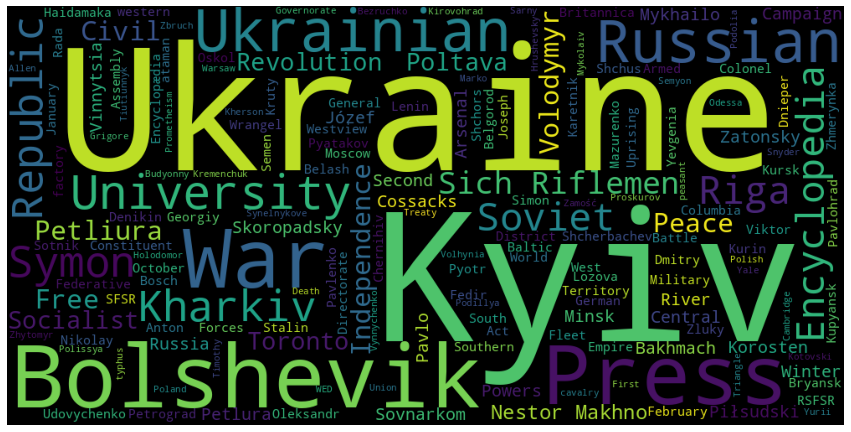

In [37]:
unique_string=(" ").join(SU_links)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

In [39]:
import nltk
freq=(nltk.FreqDist(RU_links))
print("10 most common words in the Russo-Ukrainian War")
freq.most_common(10)

10 most common words in the Russo-Ukrainian War


[('Reuters', 14),
 ('The Guardian', 12),
 ('The Moscow Times', 12),
 ('Vladimir Putin', 11),
 ('Ukrayinska Pravda', 8),
 ('Bellingcat', 8),
 ('The New York Times', 7),
 ('NATO', 7),
 ('Volodymyr Zelensky', 7),
 ('Novaya Gazeta', 7)]

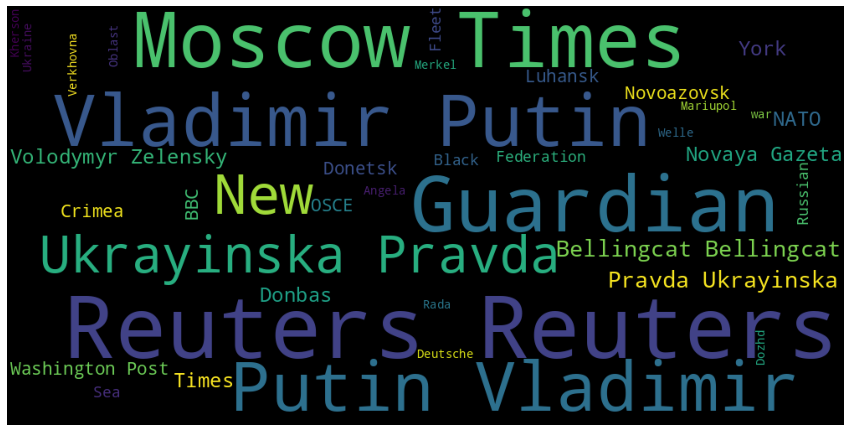

In [40]:
TFTR ={} 
c=10
for k in freq.keys():
    w=freq[k]/c
    TFTR[k]=[freq[k],w,w*freq[k]]

string = ""
for k in range (len(list(TFTR.keys()))):
    string1 = (list(TFTR.keys())[k]+" ")*int(TFTR[list(TFTR.keys())[k]][2])
    string = string1 + string

wordcloud = WordCloud(width = 1000, height = 500).generate(string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

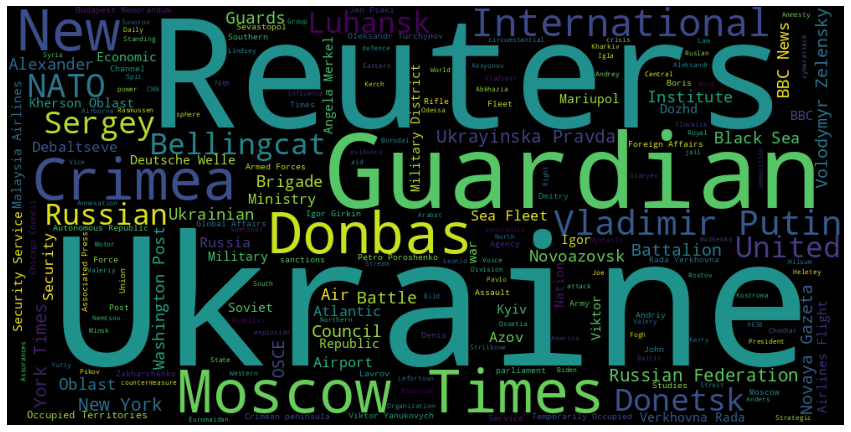

In [41]:
from wordcloud import WordCloud
unique_string=(" ").join(RU_links)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()


4. **Discussion.** Think critically about your creation
* What went well?,
Building the network took a bit of troubleshooting but in the end, it turned out well.
* What is still missing? What could be improved?, Why?
There still could be a lot more analysis done on the network, but it was difficult as we constantly were updating the structure of the network. Maybe we could have kept several different iterations of the network, and included them all as part of the website.

5. **Contributions. Who did what?**
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).
**Elias Bobrowski** did most of the analysis.

**Josep Marín Llaó** did most of the network building and visualization.

**Max Jacob Specktor** did most of the website building.

We all discussed on the project, brought ideas, scrapped and preprocessed the data and acotate the final result.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9321f69c-059e-4fca-a003-0df9ace91692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>